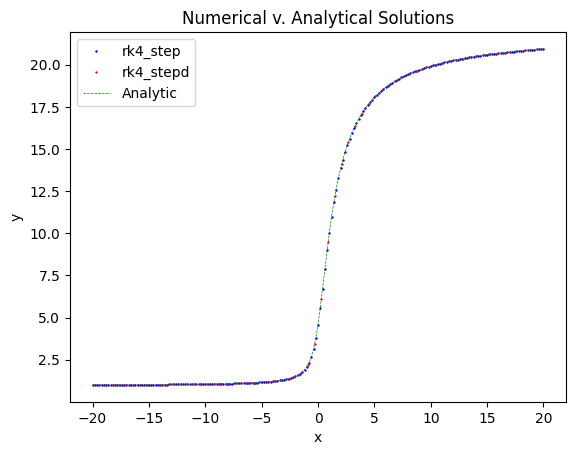

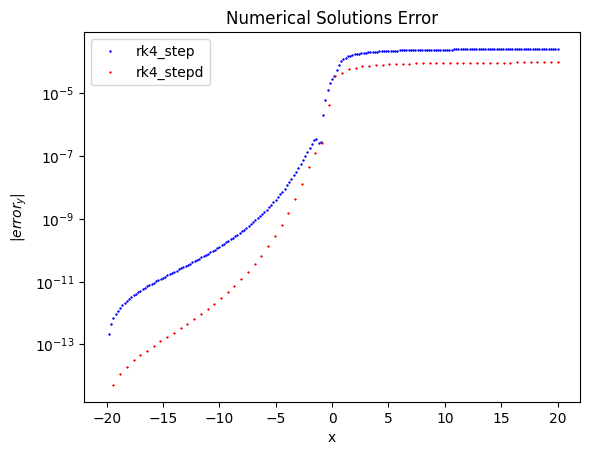

Number of calls by rk4_step 800
Number of calls by rk4_stepd 804
RMSE by rk4_step 1.6377E-04
RMSE by rk4_stepd 6.1440E-05


In [1]:
##############Assignment 3#################
###########################################
#################Problem 1#################
###########################################

import numpy as np
from matplotlib import pyplot as plt


#Parts of the code in this assignment were adapted from the lecture notes.

#solve y'=y/(1+x^2) with RK4
def f2solve(x,y):
    dydx=y/(1+x**2)
    return dydx

#array for f(x,y)
def f(x,y): 
    dydx=np.asarray([y[1],-y[0]])
    return dydx

#prototype integrator
def rk4_step(fun,x,y,h):
    k1=fun(x,y)*h
    k2=h*fun(x+h/2,y+k1/2)
    k3=h*fun(x+h/2,y+k2/2)
    k4=h*fun(x+h,y+k3)
    dy=(k1+2*k2+2*k3+k4)/6
    rk4_step.counted+=4
    return y+dy

#stepper takes a step of length h, compares that to two steps of length h/2, 
#cancel out leading-order error term from rk4
def rk4_stepd(fun,x,y,h):
    yin=rk4_step(fun,x,y,h)
    ycheck1=rk4_step(fun,x,y,h/2)
    ycheck2=rk4_step(fun,x+h/2,ycheck1,h/2)
    rk4_stepd.counted+=12
    return ycheck2 + (1/15)*(ycheck2-yin)

n=201#number of steps equal to 200
y0=1#y(-20)=1 starting point
#solve with step
x=np.linspace(-20,20,n)#x domain over which n=200 steps specified
h=np.median(np.diff(x))
rk4_step.counted=0#step calls
y=np.zeros(len(x))
y[0]=y0
for i in range(len(x)-1):
    y[i+1]=rk4_step(f2solve,x[i],y[i],h)
rk4counts=rk4_step.counted

nd=int(np.floor(4*n/12))+1#number of steps equal to 67
#solve with stepd
xd=np.linspace(-20,20,nd)#x domain over which 4*200/11 = 73 steps 
hd=np.median(np.diff(xd))
rk4_stepd.counted=0#step calls
yd=np.zeros(len(xd))
yd[0]=y0
for i in range(len(xd)-1):
    yd[i+1]=rk4_stepd(f2solve,xd[i],yd[i],hd)

    
#analytical solution
c0=(np.exp(np.arctan(-20)))**-1
truth=c0*np.exp(np.arctan(x)) #analytical solution to compare
truthd=c0*np.exp(np.arctan(xd)) #analytical solution to compare
err=np.abs(y-truth)#error of step
errd=np.abs(yd-truthd)#error of stepd

#solution plots
plt.clf();
plt.plot(x,y,'+b', ms=1,label='rk4_step')
plt.plot(xd,yd,'*r', ms=1, label='rk4_stepd')
plt.plot(x,truth,'g', ls = '--',lw =.5,label='Analytic')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Numerical v. Analytical Solutions')
plt.show()

#error plots

plt.plot(x,err,'+b', ms=1,label='rk4_step')
plt.plot(xd,errd,'*r', ms=1, label='rk4_stepd')
plt.xlabel('x')
plt.ylabel('$|error_y|$')
plt.legend()
plt.title('Numerical Solutions Error')
plt.yscale('log')
plt.show()
############

#count function calls
print('Number of calls by rk4_step', rk4counts)
print('Number of calls by rk4_stepd', rk4_stepd.counted)

#error RMSE
rmse=np.sqrt(np.sum(np.abs(y - truth)**2)/len(x))
rmsed=(np.sqrt(np.sum(np.abs(yd - truthd)**2)/len(xd)))

print('RMSE by rk4_step', f'{rmse:.4E}')
print('RMSE by rk4_stepd', f'{rmsed:.4E}')

    

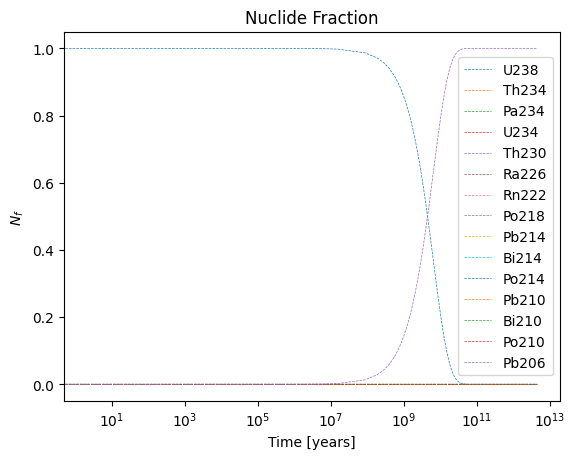

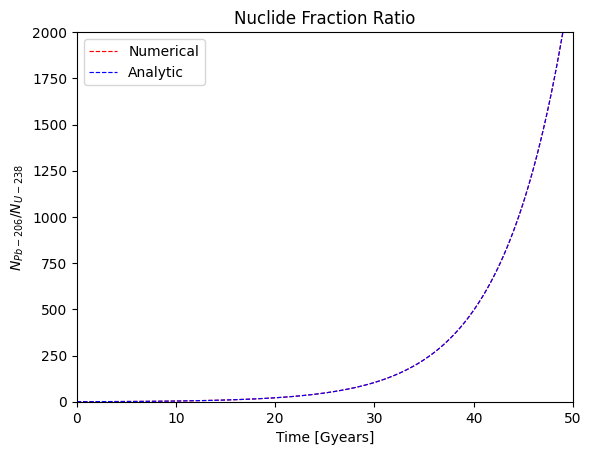

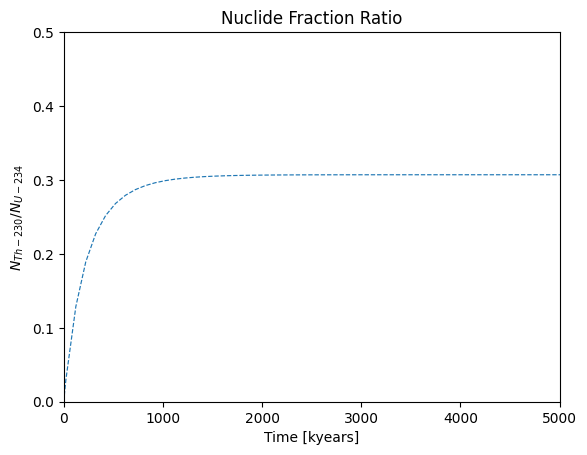

nfev =  312797


In [2]:
#################Problem 2#################
###########################################

import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate 
import astropy.units as u

#Radioactive nuclides
Nuclides = ['U238','Th234','Pa234', 'U234', 'Th230',
            'Ra226', 'Rn222','Po218','Pb214','Bi214', 
            'Po214','Pb210','Bi210','Po210', 'Pb206']
#Half-lives given units
halfs = [4.468e9*u.yr,24.10 * u.day, 6.70 * u.hr, 245500 * u.yr, 75380 * u.yr,
           1600 * u.yr, 3.8235 * u.d, 3.10 * u.min, 26.8 * u.min, 19.9 * u.min,
          164.3e-6 * u.s, 22.3 * u.yr, 5.015 * u.yr, 138376 * u.d]
#1st order rate constant k in [1/years] units
ks = []
for ha in halfs:
    ks.append(np.log(2)/(ha.to(u.yr).value))
    
#ODEs
def dNdt(t,N):
    dNdt = np.zeros(len(Nuclides))
    for ni in range(len(Nuclides)):
        #First Nuclide U238  = [U238]o-k[U238]
        if ni==0:
            dNdt[ni]= -ks[ni]*N[ni]
        #Last Nuclide Pb206  = 0 + k[Po210]
        elif ni==len(ks):
            dNdt[ni]= ks[ni-1]*N[ni-1]
        #In-between Nuclides = k[prev Nuclide] - k[this nuclide]
        else:
            dNdt[ni] = ks[ni-1]*N[ni-1] - ks[ni]*N[ni]
    return dNdt

#Nuclide quantity at t=0
N0=np.zeros(len(Nuclides))
N0[0]=1#100% U238 at t=0

#solve the initial value problem with Radau
tbot=0
ttop=1e3*halfs[0].to(u.yr).value#[years]

Nsolve= integrate.solve_ivp(dNdt, [tbot, ttop], N0, 
                            method='Radau',  max_step = 1e8) 

#plot Nfraction of all nuclides v.t
for p in range(len(Nsolve.y)):
    plt.plot(Nsolve.t, Nsolve.y[p], ls = '--',lw =.5, label=Nuclides[p])
plt.xscale('log')
plt.xlabel('Time [years]')
plt.ylabel('$N_f$')
plt.legend()
plt.title('Nuclide Fraction')
plt.show()

#plot ratio of N Pb206 to U238 v.t [Gyears]
NU=np.exp(-ks[0]*Nsolve.t)
NPb=1-np.exp(-ks[0]*Nsolve.t)
plt.plot(Nsolve.t/1e9, Nsolve.y[-1,:]/Nsolve.y[0,:], 'r', ls = '--',lw =.85, label='Numerical')
plt.plot(Nsolve.t/1e9, NPb/NU, 'b', ls = '--',lw =.85, label='Analytic')

plt.xlim([0, 5e1])#Gyears
plt.ylim([0, 2e3])
plt.xlabel('Time [Gyears]')
plt.ylabel('$N_{Pb-206}$/$N_{U-238}$')
plt.title('Nuclide Fraction Ratio')
plt.legend()
plt.show()


#evaluate ivp at a narrower domain
ttop=halfs[0].to(u.yr).value#[years]
Nsolve= integrate.solve_ivp(dNdt, [tbot, ttop], N0, 
                            method='Radau',  max_step = 1e5)
#plot ratio of N Th230 to U234 v.t [kyears]

plt.plot(Nsolve.t[1:]/1e3, Nsolve.y[4,1:]/Nsolve.y[3,1:], ls = '--',lw =.85)

plt.xlim([0, 5e3])#kyears
plt.ylim([0, 0.5])
plt.xlabel('Time [kyears]')
plt.ylabel('$N_{Th-230}$/$N_{U-234}$')
plt.title('Nuclide Fraction Ratio')
plt.show()


print("nfev = ", Nsolve.nfev)


Best fit parameters:
a= 1.6670E-04 x0= -1.3605E+00 y0= 5.8221E+01 z0 = -1.5129E+03


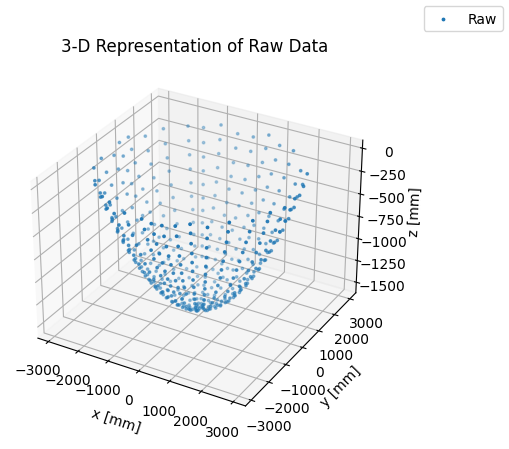

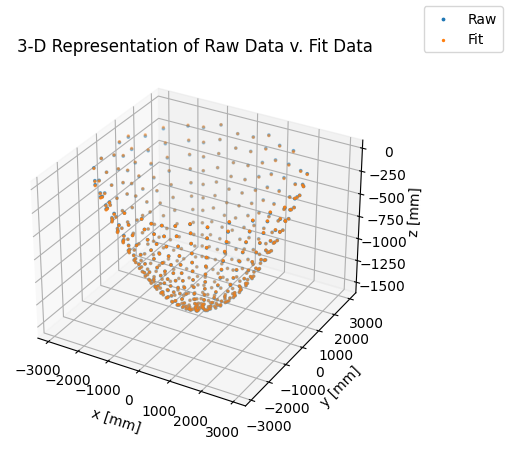

In [3]:
#################Problem 3#################
###########################################

import numpy as np
from matplotlib import pyplot as plt

#Acquire data in [mm] units
x,y,z = np.loadtxt('dish_zenith.txt').transpose()
#plot raw data
plot3d = plt.figure()
ax = plot3d.add_subplot(projection='3d')

ax.scatter3D(x, y, z, s=3, label='Raw');
plot3d.legend()
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]');
ax.set_title('3-D Representation of Raw Data')


#reparametrization
xs=len(x)
p1=x**2+y**2
p2=x
p3=y
p4=np.ones(xs)


#Fit data
M=np.vstack([p1,p2,p3,p4])
Mt=M.transpose()
d=z.transpose()
u,s,v=np.linalg.svd(Mt,0)
fit=v.T@np.diag(1/s)@u.transpose()@d
m=fit

#Evaluate fit data and plot comparison with raw
Mfit=m @ M
plot3dfit = plt.figure()
axfit = plot3dfit.add_subplot(projection='3d')
axfit.scatter3D(x, y, z, s=3, label='Raw');
axfit.scatter3D(x, y, Mfit, s=2, label='Fit');
plot3dfit.legend()
axfit.set_xlabel('x [mm]')
axfit.set_ylabel('y [mm]')
axfit.set_zlabel('z [mm]');
axfit.set_title('3-D Representation of Raw Data v. Fit Data')

#revert parameters
a=m[0]#A
x0=-m[1]/(2*m[0])#--B/(2A)
y0=-m[2]/(2*m[0])#-C/(2A)
z0=m[3]-(a*x0**2+a*y0**2)# D-ax0^2-a*y0^2
print('Best fit parameters:')
print('a=',f'{a:.4E}','x0=',f'{x0:.4E}','y0=',f'{y0:.4E}','z0 =',f'{z0:.4E}')



In [4]:
#Error Analysis
# c1=M @ Mt
# c3=np.linalg.inv(c1)
# Merr=Mt@c3@M
# # RMSE=np.sqrt(np.sum(np.diag(Merr))/len(np.diag(Merr)))
# rmse=np.sqrt(np.sum(np.abs(Mfit- z)**2)/len(z))
# RMSE=rmse
# print('RMSE=',f'{1e-3*RMSE:.4E}', 'meters')
Ns=np.mean((Mfit-z)**2)#noise estimation
merr=np.sqrt(Ns*np.diag(np.linalg.inv(M@Mt)))
#Error in a
# aerr=np.sqrt(np.diag(c3)[0])
aerr=merr[0]
print('a=',f'{1e3*a:.4E}','+/-',f'{1e3*aerr:.4E}', '1/meters')

#Focal Length f = 1/(4a)
fc=1e-3*1/(4*a)#in meters
#1st order Taylor expansion error propagation on a
print('f=',f'{fc:.4E}', '+/-',f'{1e-3*(1/(4*a**2))*aerr:.4E}', 'meters')

a= 1.6670E-01 +/- 6.4519E-05 1/meters
f= 1.4997E+00 +/- 5.8041E-04 meters


In [5]:
#Rotational elliptical
#reparametrization

p1=x**2
p2=y**2
p3=x*y
p4=x
p5=y
p6=np.ones(xs)

#Fit data
M=np.vstack([p1,p2,p3,p4,p5,p6])
Mt=M.transpose()
d=z.transpose()
# c1=M @ Mt
# c2=M @ z
# m = np.linalg.inv(c1) @ c2

u,s,v=np.linalg.svd(Mt,0)
fit2=v.T@np.diag(1/s)@u.transpose()@d

m= (Mt@fit2)
# print(m)

#revert parameters
A=fit2[0]
B=fit2[1]
C=fit2[2]
theta=0.5*(np.arctan(C/(A-B)))
cs2=(np.cos(theta))**2
sn2=(np.sin(theta))**2
a=(A*cs2-B*sn2)/(cs2**2-sn2**2)
b=(A*sn2-B*cs2)/(sn2**2-cs2**2)
print('Best fit parameters:')
print('a=',f'{a:.4E}','b=',f'{b:.4E}','theta=',f'{theta:.4E}')
fa=1e-3*1/(4*a)#in meters
fb=1e-3*1/(4*b)#in meters
#Elliptical parameters
print('fa=',f'{fa:.4E}', ' ','fb=',f'{fb:.4E}', 'meters')


Best fit parameters:
a= 1.6573E-04 b= 1.6776E-04 theta= -6.2000E-01
fa= 1.5085E+00   fb= 1.4902E+00 meters
